# **Reading Data**

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d gpiosenka/sports-classification

 97% 410M/424M [00:03<00:00, 138MB/s]
100% 424M/424M [00:03<00:00, 126MB/s]


In [ ]:
! unzip \*zip

Streaming output truncated to the last 5000 lines.
  inflating: train/rings/022.jpg     
  inflating: train/rings/023.jpg     
  inflating: train/rings/024.jpg     
  inflating: train/rings/025.jpg     
  inflating: train/rings/026.jpg     
  inflating: train/rings/027.jpg     
  inflating: train/rings/028.jpg     
  inflating: train/rings/029.jpg     
  inflating: train/rings/030.jpg     
  inflating: train/rings/031.jpg     
  inflating: train/rings/032.jpg     
  inflating: train/rings/033.jpg     
  inflating: train/rings/034.jpg     
  inflating: train/rings/035.jpg     
  inflating: train/rings/036.jpg     
  inflating: train/rings/037.jpg     
  inflating: train/rings/038.jpg     
  inflating: train/rings/039.jpg     
  inflating: train/rings/040.jpg     
  inflating: train/rings/041.jpg     
  inflating: train/rings/042.jpg     
  inflating: train/rings/043.jpg     
  inflating: train/rings/044.jpg     
  inflating: train/rings/045.jpg     
  inflating: train/rings/046.jpg     

# **Exploration**

In [ ]:
import numpy as np
import pandas as pd
import os
import random
from PIL import Image
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.optimizers import Adam

In [ ]:
train_dir = '/content/train'
test_dir = '/content/test'
valid_dir = '/content/valid'

In [ ]:
def show_random_images_with_labels(main_folder, num_images=5):
  """
  Displays a random selection of images from subfolders of the main folder,
  along with their corresponding labels (subfolder names).

  Args:
    main_folder: Path to the main folder containing subfolders of images.
    num_images: Number of images to display (default: 5).
  """

  subfolders = [os.path.join(main_folder, f) for f in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, f))]
  random.shuffle(subfolders)  # Randomize the order of subfolders

  fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(15, 5))
  for i, subfolder in enumerate(subfolders[:num_images]):
    image_paths = [os.path.join(subfolder, f) for f in os.listdir(subfolder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(image_paths)  # Randomize the order of images within the subfolder
    image_path = image_paths[0]  # Select the first random image

    img = Image.open(image_path)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(os.path.basename(image_path) + f" ({os.path.basename(subfolder)})", fontsize=10)  # Add label in title

  plt.tight_layout()
  plt.show()

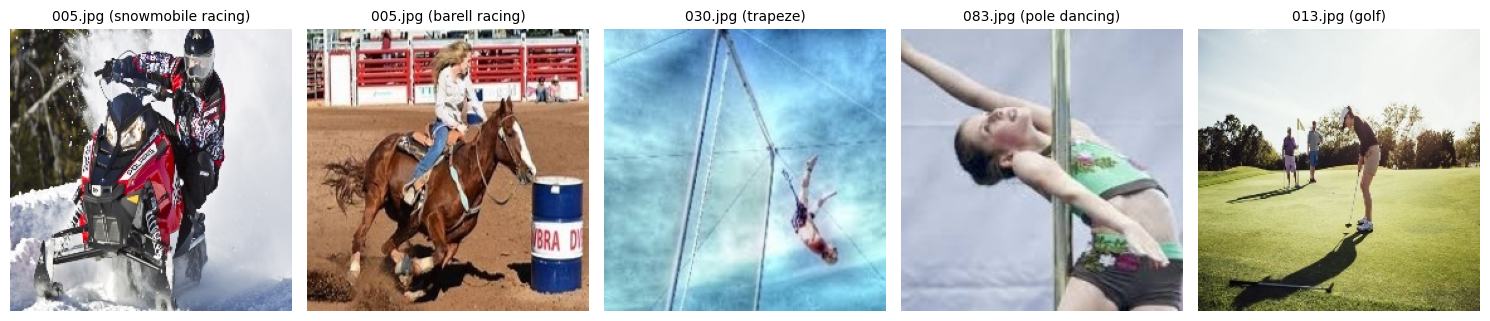

In [ ]:
show_random_images_with_labels(train_dir,5)

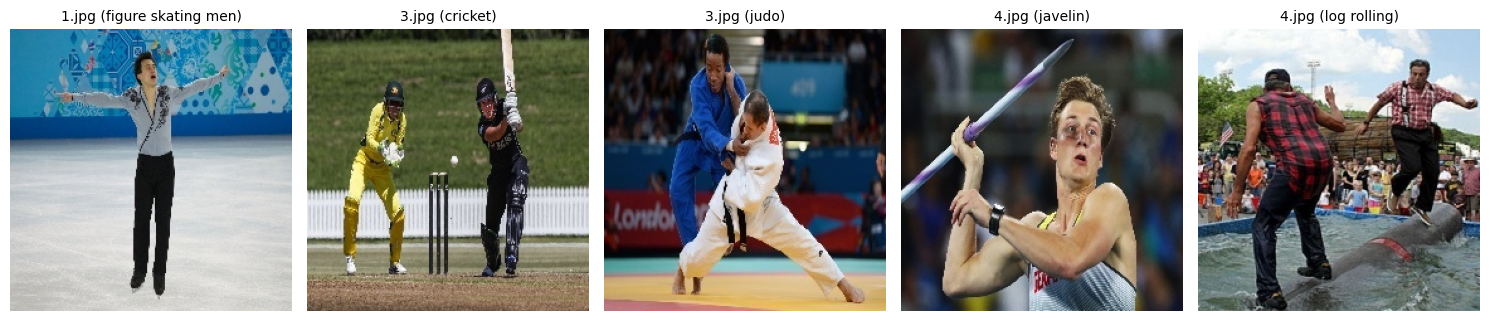

In [ ]:
show_random_images_with_labels(test_dir,5)

In [ ]:
df = pd.read_csv('/content/sports.csv')

In [ ]:
df.head(5)

,class id,filepaths,labels,data set
0,0,train/air hockey/001.jpg,air hockey,train
1,0,train/air hockey/002.jpg,air hockey,train
2,0,train/air hockey/003.jpg,air hockey,train
3,0,train/air hockey/004.jpg,air hockey,train
4,0,train/air hockey/005.jpg,air hockey,train


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14493 entries, 0 to 14492
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   class id   14493 non-null  int64 
 1   filepaths  14493 non-null  object
 2   labels     14493 non-null  object
 3   data set   14493 non-null  object
dtypes: int64(1), object(3)
memory usage: 453.0+ KB


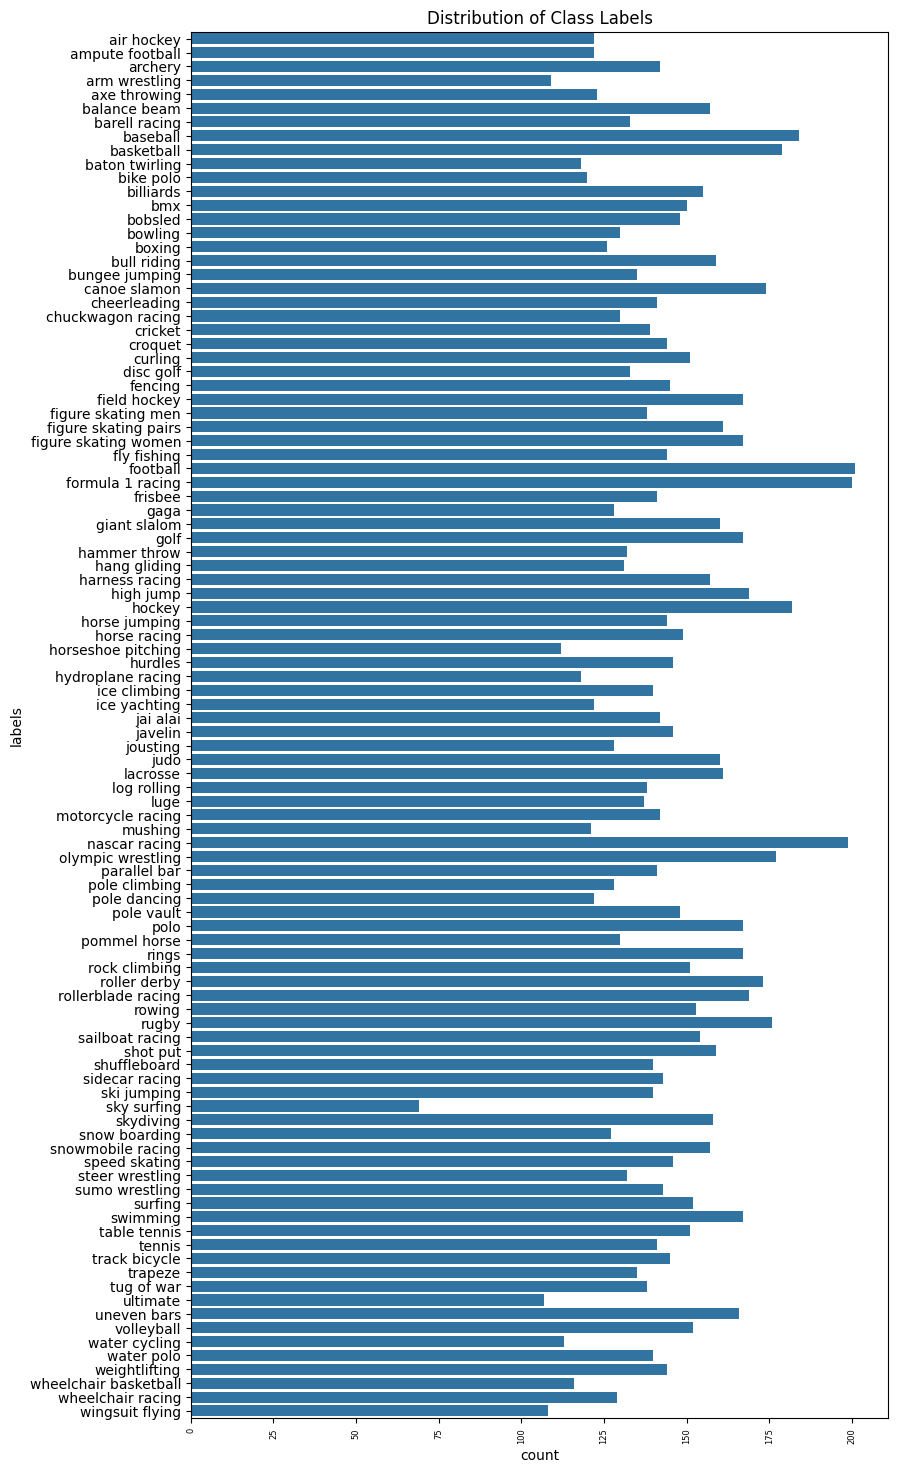

In [ ]:
import seaborn as sns
plt.figure(figsize=(9, 18))
sns.countplot(y='labels', data=df)
plt.title('Distribution of Class Labels')
plt.xticks(rotation=90, fontsize=6)
plt.show()

In [ ]:
df.shape

(14493, 4)

In [ ]:
df.nunique()

class id       100
filepaths    14493
labels         100
data set         3
dtype: int64

In [ ]:
df.duplicated().sum()

0

train    13493
test       500
valid      500
Name: data set, dtype: int64


<Axes: >

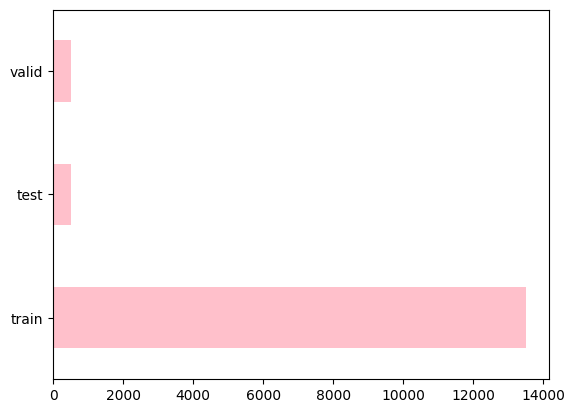

In [ ]:
print(df['data set'].value_counts())
df['data set'].value_counts().plot.barh(color='pink')

In [ ]:
minoo = pd.crosstab(df["data set"] , df["labels"])
minoo

labels,air hockey,ampute football,archery,arm wrestling,axe throwing,balance beam,barell racing,baseball,basketball,baton twirling,...,tug of war,ultimate,uneven bars,volleyball,water cycling,water polo,weightlifting,wheelchair basketball,wheelchair racing,wingsuit flying
data set,,,,,,,,,,,,,,,,,,,,,
test,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
train,112,112,132,99,113,147,123,174,169,108,...,128,97,156,142,103,130,134,106,119,98
valid,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5


In [ ]:
df.isnull().sum()

class id     0
filepaths    0
labels       0
data set     0
dtype: int64

## **MODELING**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense,Flatten
from keras.models import Sequential
from keras.applications import EfficientNetB0

In [ ]:
train_ds=keras.utils.image_dataset_from_directory(
    directory=train_dir,
    image_size=(256,256),
    labels='inferred',
    label_mode='int',
    batch_size=32
)
test_ds=keras.utils.image_dataset_from_directory(
    directory=test_dir,
    image_size=(256,256),
    labels='inferred',
    label_mode='int',
    batch_size=32
)
valid_ds=keras.utils.image_dataset_from_directory(
    directory=valid_dir,
    image_size=(256,256),
    labels='inferred',
    label_mode='int',
    batch_size=32
)

Found 13492 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
Found 500 files belonging to 100 classes.


In [ ]:
base_model=EfficientNetB0(include_top=False,input_shape=(256,256,3),weights='imagenet')

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers:
  layer.trainable=False

In [ ]:
model=Sequential()

model.add(base_model)
model.add(Flatten())

model.add(Dense(512,activation='relu'))
model.add(keras.layers.BatchNormalization(momentum=0.99,epsilon=0.001))
model.add(keras.layers.Dropout(0.2))
model.add(Dense(256,activation='relu'))
model.add(keras.layers.BatchNormalization(momentum=0.99,epsilon=0.001))
model.add(keras.layers.Dropout(0.1))
model.add(Dense(100,activation='softmax'))

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-4),metrics=['accuracy'])

In [ ]:
history=model.fit(train_ds,validation_data=test_ds,epochs=10)

Epoch 1/10
422/422 [==============================] - 1750s 4s/step - loss: 1.1411 - accuracy: 0.7504 - val_loss: 0.2204 - val_accuracy: 0.9460
Epoch 2/10
422/422 [==============================] - 1727s 4s/step - loss: 0.1456 - accuracy: 0.9781 - val_loss: 0.1587 - val_accuracy: 0.9600
Epoch 3/10
422/422 [==============================] - 1749s 4s/step - loss: 0.0311 - accuracy: 0.9970 - val_loss: 0.1304 - val_accuracy: 0.9600
Epoch 4/10
422/422 [==============================] - 1769s 4s/step - loss: 0.0122 - accuracy: 0.9989 - val_loss: 0.1289 - val_accuracy: 0.9640
Epoch 5/10
422/422 [==============================] - 1745s 4s/step - loss: 0.0069 - accuracy: 0.9995 - val_loss: 0.1065 - val_accuracy: 0.9680
Epoch 6/10
422/422 [==============================] - 1684s 4s/step - loss: 0.0050 - accuracy: 0.9993 - val_loss: 0.1002 - val_accuracy: 0.9700
Epoch 7/10
422/422 [==============================] - 1754s 4s/step - loss: 0.0027 - accuracy: 0.9998 - val_loss: 0.0983 - val_accuracy:

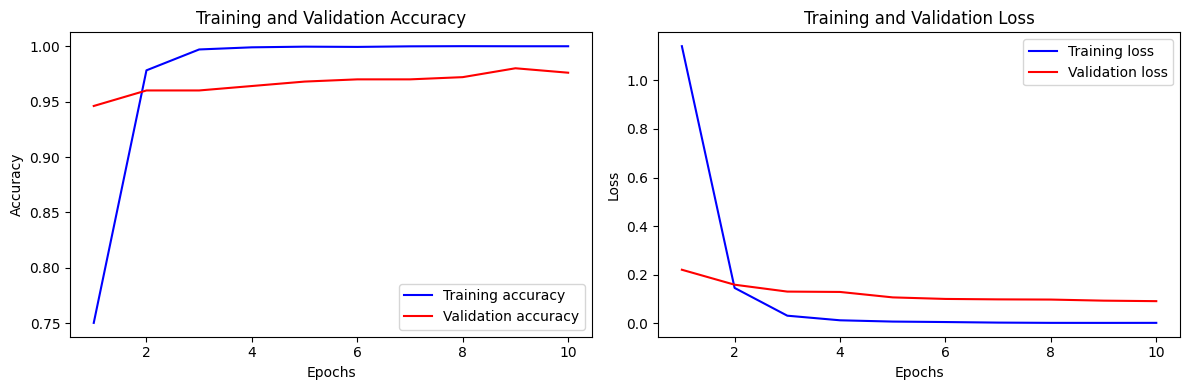

In [ ]:
 # Extracting training and validation metrics from the history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

    # Plotting accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

    # Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
predictions=model.evaluate(valid_ds)

16/16 [==============================] - 53s 3s/step - loss: 0.1182 - accuracy: 0.9660


In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize,Compose, Normalize, ToTensor
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torch import nn
from torch.optim import Adam
import torch
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

In [ ]:
train_data=ImageFolder('/content/train',transform=Compose([ToTensor(),Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])]))
test_data=ImageFolder('/content/test',transform=Compose([ToTensor(),Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])]))
valid_data=ImageFolder('/content/valid',transform=Compose([ToTensor(),Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])]))

In [ ]:
train_loader=DataLoader(train_data,batch_size=4,shuffle=True)
test_loader=DataLoader(test_data,batch_size=4)
val_loader=DataLoader(valid_data,batch_size=4)

In [ ]:
model=resnet18(pretrained=True)
model.fc=nn.Linear(512,len(train_data.classes))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 52.6MB/s]


In [ ]:
print(torch.__version__, torch.cuda.is_available())

2.1.0+cu121 False


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming you have defined your data loaders and modified the model as mentioned earlier
# train_loader, test_loader, val_loader
# model = resnet18(pretrained=True)
# model.fc = nn.Linear(512, len(train_data.classes))

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 10  # Adjust the number of epochs as needed

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()

    # Print training loss for each epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {running_loss / len(train_loader)}")

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Print validation loss and accuracy for each epoch
    print(f"Validation Loss: {val_loss / len(val_loader)}, Validation Accuracy: {100 * correct / total}%")

# After training, you can evaluate the model on the test set
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print test loss and accuracy
print(f"Test Loss: {test_loss / len(test_loader)}, Test Accuracy: {100 * correct / total}%")


Epoch 1/10, Training Loss: 2.0173648013922465
Validation Loss: 0.49917795228523026, Validation Accuracy: 84.8%
Epoch 2/10, Training Loss: 0.8235020964731413
Validation Loss: 0.3065584173438074, Validation Accuracy: 89.8%
Epoch 3/10, Training Loss: 0.4758826752143296
Validation Loss: 0.2841114545118616, Validation Accuracy: 91.8%
Epoch 4/10, Training Loss: 0.3066247347516253
Validation Loss: 0.26447353532195483, Validation Accuracy: 91.2%
Epoch 5/10, Training Loss: 0.20444904008391956
Validation Loss: 0.22608542832402595, Validation Accuracy: 93.4%
Epoch 6/10, Training Loss: 0.13663083425538505
Validation Loss: 0.17696280886907745, Validation Accuracy: 95.0%
Epoch 7/10, Training Loss: 0.10666498667631616
Validation Loss: 0.2023055139281512, Validation Accuracy: 94.8%
Epoch 8/10, Training Loss: 0.0851624141700414
Validation Loss: 0.20748345476278338, Validation Accuracy: 95.0%


In [ ]:
import torch
from torchvision import transforms
from PIL import Image

# Assuming you have a function to load and preprocess an image
def load_and_preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Adjust the size to match the input size of your model
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Assuming ImageNet normalization
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)  # Add batch dimension

def predict_single_image(model, image_path):
    model.eval()  # Set the model to evaluation mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load and preprocess the image
    input_tensor = load_and_preprocess_image(image_path)
    input_tensor = input_tensor.to(device)

    # Make the prediction
    with torch.no_grad():
        output = model(input_tensor)

    # Get the predicted class index
    _, predicted_class = torch.max(output, 1)

    return predicted_class.item()

# Example usage:
# image_path = 'path/to/your/image.jpg'
# predicted_class = predict_single_image(model, image_path)
# print(f"The predicted class index is: {predicted_class}")


In [ ]:
image_path = '/content/test/arm wrestling/1.jpg'
predicted_class = predict_single_image(model, image_path)
print(f"The predicted class index is: {predicted_class}")

The predicted class index is: 163


In [ ]:
def get_test_image(category: str, number: int):
    """
    Get a image from the test dataset by kind of sport (name of folder) and image number
    """
    image_path = '/content/test'
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [ ]:
import sys
import cv2
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [ ]:
def get_class_name(class_id):
    """
    Get class name by class id
    """
    return df.loc[df["class id"] == class_id].iloc[0]["labels"]

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

In [ ]:
# define preprocess transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

In [ ]:
def single_image_predict(model, image, loss_fn, device):
    """
    Function to predict the label of a single image
    """

    model.eval()
    image = transform(image)
    # add batch dimension
    image = torch.unsqueeze(image, 0)
    with torch.no_grad():
        outputs = model(image.to(device))
    output_label = torch.topk(outputs, 1)
    pred_class_id = int(output_label.indices)
    pred_class_name = get_class_name(pred_class_id)

    return  pred_class_name